# Multi Layer Perceptron application

Unlike the previous sinlge layer perceptron, this notebook aims to achieve a **context** based understanding input characters more than the immediate previous character.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

Creating a mapping of character to index

In [8]:
vocab = sorted(list(set("".join(words))))
ch_to_idx = {ch:idx+1 for idx,ch in enumerate(vocab)}
ch_to_idx['.'] =0
idx_to_ch = {idx:ch for ch,idx in ch_to_idx.items()}
print(idx_to_ch)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Creating a context based dataset 

In [26]:
block_size = 3
X,Y = [],[]

for w in words[:5]:
    print(w)
    context = [0] * block_size

    for ch in w + '.':
        ix = ch_to_idx[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(idx_to_ch[i] for i in context), '--->', idx_to_ch[ix])
        print('+'.join(f'{i}' for i in context), '--->', f'{ix}')
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
0+0+0 ---> 5
..e ---> m
0+0+5 ---> 13
.em ---> m
0+5+13 ---> 13
emm ---> a
5+13+13 ---> 1
mma ---> .
13+13+1 ---> 0
olivia
... ---> o
0+0+0 ---> 15
..o ---> l
0+0+15 ---> 12
.ol ---> i
0+15+12 ---> 9
oli ---> v
15+12+9 ---> 22
liv ---> i
12+9+22 ---> 9
ivi ---> a
9+22+9 ---> 1
via ---> .
22+9+1 ---> 0
ava
... ---> a
0+0+0 ---> 1
..a ---> v
0+0+1 ---> 22
.av ---> a
0+1+22 ---> 1
ava ---> .
1+22+1 ---> 0
isabella
... ---> i
0+0+0 ---> 9
..i ---> s
0+0+9 ---> 19
.is ---> a
0+9+19 ---> 1
isa ---> b
9+19+1 ---> 2
sab ---> e
19+1+2 ---> 5
abe ---> l
1+2+5 ---> 12
bel ---> l
2+5+12 ---> 12
ell ---> a
5+12+12 ---> 1
lla ---> .
12+12+1 ---> 0
sophia
... ---> s
0+0+0 ---> 19
..s ---> o
0+0+19 ---> 15
.so ---> p
0+19+15 ---> 16
sop ---> h
19+15+16 ---> 8
oph ---> i
15+16+8 ---> 9
phi ---> a
16+8+9 ---> 1
hia ---> .
8+9+1 ---> 0


In [28]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Going forward, similar to one hot encoding of the inputs, we can represent the input using a 2 dimensional vector or an n dimensional vector. 

In one hot encoding, for a vocab size of 5 and encoding num class size of 5, will mark each input's row as 1 at the index and rest 0. 

In an n dimensional vector, the encoding can be seem different but is essentially the same, the input is being distributed among the dimensions (similar to num classes in one hot encoding) where row is a unique identifier for an input. 

In [37]:
C = torch.randn((27,2))

In [38]:
C[5]

tensor([ 0.5437, -0.8155])

Instead of writing 5, [0.5437,-0.81551] communicates the same.

The original tensor X is of the shape 32,3: 32 different inputs, where each of them is made up of 3 different numbers out of the voab of 27 characters.

After embedding them using C, X will still be a 32 by 3 tensor with an additional dimension of 2, this 2 will represent each individual character(out of the three) which comprises an input. 

For example: 
Input 5 can be imagined as -> 5th row, having 3 columns(representing the 3 comprising characters), and each of the 3 columns are represented using 2 sub columns to show the same character using the embedded representation.

In [40]:
C[X].shape

torch.Size([32, 3, 2])

In [44]:
X[7,1] # 7th input's second character

tensor(15)

In [46]:
C[X][7,1] # same character embedded in a 2 dimensional vector

tensor([ 1.6076, -1.5196])

In [47]:
embeds = C[X]
embeds.shape

torch.Size([32, 3, 2])

Initializing weights and biases for the nerual net layer. Since from each input, there are 3 characters where each character has an embedding of 2, so 3*2 = 6 weights are required per neuron. 

In [50]:
W1 = torch.randn((6,100)) # creating a 100 neurons in the first layer
b1 = torch.randn(100) # creating bias for 100 neurons

As of now, W(6,32) and embeds(32,3,2) are not of the shapes compatible for a matrix multiplication.

To convert W to (32,6):

In [54]:
# this can be read as:
embeds[:,0,:]
# from all the inputs, select the first character, and give both embeddings

# hence this will be of the shape 32,2
# similarly, we need to find tensors of other two charcters in an input as well and concatenate all
# to create a single matrix of all 32 inputs and all 6 embedding representations
# 32,6

tensor([[ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 5.4367e-01, -8.1549e-01],
        [ 8.7726e-01,  1.1749e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 1.6076e+00, -1.5196e+00],
        [-1.5131e-01,  8.5584e-01],
        [ 5.8478e-01,  1.1425e+00],
        [-9.5415e-01, -1.7303e+00],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 7.9055e-01, -2.8307e+00],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 5.8478e-01,  1.1425e+00],
        [-1.1815e+00, -9.8178e-01],
        [ 7.9055e-01, -2.8307e+00],
        [ 4.8101e-02, -1.8436e-01],
        [ 5.4367e-01, -8.1549e-01],
        [-1.5131e-01,  8.5584e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.1491e-01],
        [ 6.7313e-01, -9.149

In [58]:
torch.cat([embeds[:,0,:],embeds[:,1,:],embeds[:,2,:]], dim=1).shape

torch.Size([32, 6])

In [60]:
# to get the list passed into cat above, 
len(torch.unbind(embeds,dim =1))

3

This generalizes our code to be able to perform this operation irrespective of the block size mentioned.

However, the cat method is not efficient since it creates a new tensor hence allocating more space.

In [61]:
torch.cat(torch.unbind(embeds,dim = 1),dim = 1).shape

torch.Size([32, 6])

Another way to go around this is by leveraging the **storage** and **view** property of a tensor. 

assume a tensor t, t.storage() contains all(12) the elements present inside the tensor. As long as the total number of elements is maintianed, the tensor can be represented in any dimensional format using view.

for example: 

t.view(6,2)
t.view(2,6)
t.view(3,2,2)
t.view(4,3), etc and etc

In [64]:
t = torch.arange(12)

In [63]:
t.storage()

/var/folders/ph/5hgyd1hn7dgcjfc5l9h535tc0000gn/T/ipykernel_20156/1911556638.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 10]

In [67]:
t.view(2,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]]])

Multiplication to achieve hidden states:

In [71]:
h = torch.tanh(embeds.view(embeds.shape[0],6) @ W1 + b1)

In [70]:
h.shape

torch.Size([32, 100])

In [72]:
h

tensor([[ 0.6539,  0.9206, -0.7172,  ..., -0.9792, -0.8934,  0.9744],
        [ 0.4943,  0.9098, -0.7511,  ..., -0.9784, -0.8942,  0.9670],
        [-0.7213,  0.9239, -0.8285,  ..., -0.9558, -0.7211,  0.9293],
        ...,
        [-1.0000, -0.4245,  0.7901,  ..., -0.9976, -0.9246, -0.9766],
        [-0.9254,  0.3353, -0.9545,  ...,  0.0908,  0.4027,  0.1824],
        [ 1.0000,  0.4070,  0.9891,  ..., -0.9974,  0.7209,  0.9902]])

In [76]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [77]:
logits = h @ W2 + b2

In [79]:
logits.shape

torch.Size([32, 27])

In [80]:
counts = logits.exp()

In [81]:
probab = counts / counts.sum(dim = 1, keepdim=True)

In [82]:
probab.shape

torch.Size([32, 27])

torch.arange(32) gives values 0 to 31, representing all the 32 outputs (consider this as i), 

**keep in mind probab is of shape 32,27 where 27 represents the vocab size**

For each of those i, Y[i] (which is the true label(next true character)) is extracted.

This makes Probab[i,Y[i]] give the probability of Y[i] being the output of the ith input. 

In [87]:
probab[torch.arange(32), Y]

tensor([3.1370e-07, 1.0844e-04, 1.8914e-01, 1.9146e-05, 1.5718e-01, 8.7319e-06,
        9.9883e-07, 1.6284e-07, 2.3133e-15, 5.1365e-06, 1.3431e-13, 2.5157e-08,
        6.5754e-03, 3.9146e-12, 3.8384e-04, 2.4137e-11, 1.0761e-06, 1.0851e-06,
        5.5248e-01, 1.8660e-03, 5.2377e-14, 8.4863e-06, 4.2127e-10, 3.6808e-07,
        3.8103e-01, 1.4696e-09, 4.7032e-05, 4.7789e-08, 7.1945e-01, 2.4122e-08,
        1.2160e-11, 9.4102e-01])

Ideally, the output of this should be all 1, since they are the true next characters.

The probabilites of occurance of actual next characters for input is very low, which indicates that the network is not performing well. (obviously since it is not yet trained)

In [91]:
loss = -probab[torch.arange(32), Y].log().mean()
loss # negative log likelihood loss

tensor(13.7625)

calculating loss using pytorch:

In [92]:
loss = F.cross_entropy(logits, Y)
loss

tensor(13.7625)

Summary of the neural net parameters:

In [94]:
parameters = [C,W1,b1,W2,b2]
total_params = sum(p.nelement() for p in parameters)
total_params

3481

Setting the training step:

In [106]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

In [107]:
for p in parameters:
    p.requires_grad = True

In [108]:
for _ in range(1000):
    # forward pass
    embeds = C[X] 
    h = torch.tanh(embeds.view(embeds.shape[0],6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # updating parameters
    for p in parameters:
        p.data += -0.1 * p.grad

17.76971435546875
13.656402587890625
11.298770904541016
9.452457427978516
7.984264373779297
6.891321182250977
6.100014686584473
5.452036380767822
4.898151874542236
4.414664268493652
3.9858498573303223
3.6028308868408203
3.262141466140747
2.961381196975708
2.6982975006103516
2.469712495803833
2.2716610431671143
2.1012837886810303
1.9571774005889893
1.8374857902526855
1.7380964756011963
1.6535117626190186
1.5790901184082031
1.5117672681808472
1.4496049880981445
1.391312599182129
1.335992693901062
1.2830532789230347
1.232191801071167
1.1833819150924683
1.1367990970611572
1.0926649570465088
1.0510928630828857
1.012027382850647
0.9752706289291382
0.9405569434165955
0.907612681388855
0.8761923909187317
0.8460896015167236
0.8171358704566956
0.7891994714736938
0.7621749043464661
0.7359817624092102
0.710558295249939
0.685861349105835
0.6618653535842896
0.6385660171508789
0.6159822940826416
0.5941660404205322
0.5732106566429138
0.5532564520835876
0.5344884991645813
0.5171173214912415
0.501331686

Redefine the X and Y tensors to accomodate the entire dataset and run network agian

In [110]:
block_size = 3
X,Y = [],[]

for w in words:
    # print(w)
    context = [0] * block_size

    for ch in w + '.':
        ix = ch_to_idx[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(idx_to_ch[i] for i in context), '--->', idx_to_ch[ix])
        # print('+'.join(f'{i}' for i in context), '--->', f'{ix}')
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [112]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [111]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

for _ in range(10):
    # forward pass
    embeds = C[X] 
    h = torch.tanh(embeds.view(embeds.shape[0],6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # updating parameters
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.08448600769043
15.776531219482422
14.833338737487793
14.002596855163574
13.253255844116211
12.579915046691895
11.983097076416016
11.470491409301758
11.05185604095459


Instead of doing a forward and backward pass on all 228146 inputs, a batch wise feeding is more optimal.

This code creates 32 random numbers between 0 and 228146.

In [114]:
torch.randint(0,X.shape[0],(32,))

tensor([189961, 199000, 226334,  13372, 108055,  46234, 147224, 187655, 209012,
         89834, 182681,  21801, 152483, 110114,   7443,  25768, 155759, 136238,
        194484, 105412,  76786, 154462,  94756, 211922, 197173, 101456,  12705,
         97112,  46783, 218754,  21526, 109948])

implementing batches in training

In [211]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

In [156]:
for _ in range(1000):
    # batches
    batch_indexes = torch.randint(0, X.shape[0], (32,))

    # forward pass
    embeds = C[X[batch_indexes]] 
    h = torch.tanh(embeds.view(embeds.shape[0],6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[batch_indexes])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # updating parameters
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.5851738452911377


Gradients calculated in batch wise training vs all instance trainings vary in accuracy. The gradients calculated in **all instance trainings** are much more **accurate**, however this is **not advised**, it is recommended to have more steps during training using batches rather than having accurate gradients to converge faster.  

Learning Rate Determination:

How fast or slow can help a model converge faster or overshoot the minimum. A dynamic range of learning rates can be set.

In [212]:
lre = torch.linspace(-3,0,steps = 1000)
lrs = 10**lre

In [219]:
lr_log = []
lr_exponent_log = []
lr_loss_log = []

for i in range(1000):
    # batches
    batch_indexes = torch.randint(0, X.shape[0], (32,))

    # forward pass
    embeds = C[X[batch_indexes]] 
    h = torch.tanh(embeds.view(embeds.shape[0],6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[batch_indexes])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # updating parameters
    lr = lrs[i]
    for p in parameters:
        # p.data += -0.1 * p.grad
        p.data += -lr * p.grad

    lr_log.append(lr)
    lr_exponent_log.append(lre[i])
    lr_loss_log.append(loss.item())

print(loss.item())

2.963762044906616


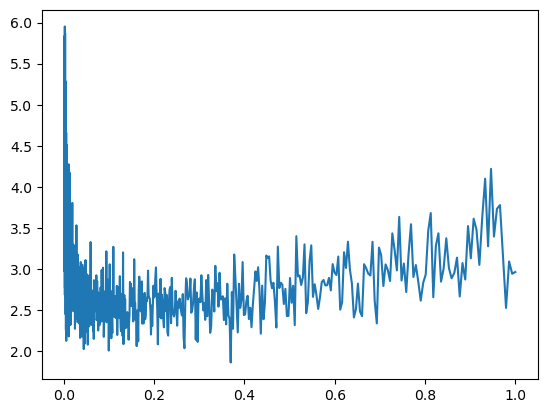

In [220]:
plt.plot(lr_log,lr_loss_log)

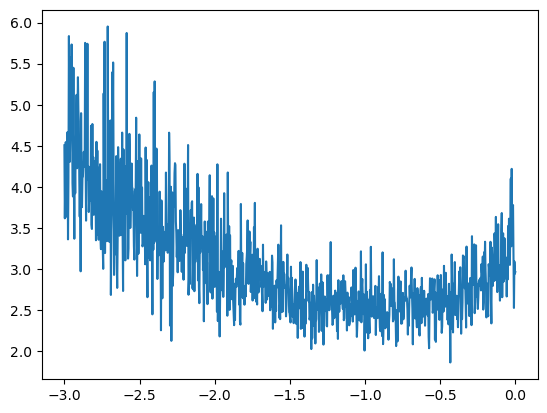

In [221]:
plt.plot(lr_exponent_log, lr_loss_log)

Through the graph of log_exponents we can find the appropriate exponent for 10 to be set for learning rate.

At the end stages of learning (when the loss goes really low), implement learning rate decay, which means reducing the learning rate by a factor to slow down the gradient descent step and repeat the steps to further optimize the model.

Training, dev/validation, test split
80%, 10%, 10%
validation split is used for hyperparameters tuning.

Hyperparameters are the size of the hidden layer, size of embedding, regularizatoin etc.

In [ ]:
def build_dataset(words):
    block_size = 3
    X,Y = [],[]

    for w in words:
        # print(w)
        context = [0] * block_size

        for ch in w + '.':
            ix = ch_to_idx[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(idx_to_ch[i] for i in context), '--->', idx_to_ch[ix])
            # print('+'.join(f'{i}' for i in context), '--->', f'{ix}')
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = 0.8 * len(words)
n2 = 0.9 * len(words)

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[:n2])

If the training loss and validation loss is very similar, that indicates underfitting. 

Sampling:

In [223]:
g = torch.Generator().manual_seed(2147483647)

# creating 10 names
for _ in range(10):

    context = [0] * block_size
    output = []
    flag = True
    while flag:

        embed = C[torch.tensor([context])]
        h = torch.tanh(embed.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        # count = logits.exp()
        # probab = count / count.sum(1,keepdim=True)
        probab = F.softmax(logits, dim = 1)

        next_ix = torch.multinomial(probab, num_samples=1, replacement=True,generator=g).item()
        output.append(idx_to_ch[next_ix])
        context = context[1:] + [next_ix]

        if next_ix == 0:
            flag = False

    print(''.join(output))

cee.
maioaleunaice.
veyha.
venimi.
nain.
lenan.
man.
a.
rleinauhlanhe.
ile.
